# *** Note that ***
# To run this notebook, you need GPU

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preporcessing
from preprocessing import cleaning
from sklearn.model_selection import train_test_split

# model
from dataset import BertDataset
from model import BERT
from transformers import BertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from loss import focal_loss

# train and evaluate
from utils import train_model, evaluation, train_submit_model, prediction

# evaluating
from sklearn.metrics import confusion_matrix, classification_report

# Import train and test data

In [2]:
# import data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
# check data size
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [4]:
# check train data
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [5]:
# check test data
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


# Preprocessing

In [6]:
# cleaninf description of both train and test data
# delte html tag such as <li>

cleaned_train = cleaning(train, training=True)
cleaned_test = cleaning(test, training=False)

In [7]:
# check data after cleaning
print('#original\n', train['description'][0])
print("-----")
print('#cleaned\n', cleaned_train['description'][0])

#original
 <li>Develop cutting-edge web applications that perform superbly across all platforms.</li><li>Work in a highly collaborative environment with cross-functional teams on projects ranging from a few weeks to a few months in length.</li><li>Maintain high standard of quality as you creatively and strategically problem solve throughout the product delivery process.</li><li>Be able to effectively communicate your work with both technical and non-technical peers</li><li>Be excited about new web technologies/techniques</li><li>Build solid front-end architectures that integrate easily with other systems and technologies</li><li>Working closely with other disciplines (Back-end, UX, Design, QA)</li><li>Have a superior attention to detail and a strong ability to Q/A one\'s own work required, including cross-browser and cross-platform displays and performance</li></ul>
-----
#cleaned
  Develop cutting-edge web applications that perform superbly across all platforms. Work in a highly colla

In [8]:
print(cleaned_train['description'].shape)
print(cleaned_train['jobflag'].head())

(1516,)
0    2
1    2
2    3
3    2
4    3
Name: jobflag, dtype: int64


In [9]:
# split train and validation data
data_train, data_valid = train_test_split(cleaned_train, stratify=cleaned_train['jobflag'], test_size=0.3, random_state=0)

# Model

before using transformers, install transformers from huggingface  
`conda install -c huggingface transformers`

In [10]:
# hyper-parameters
epochs = 5
batch_size = 128
max_length = 512

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [12]:
train_dataset = BertDataset(data_train, tokenizer, max_length=max_length, training=True) 
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [13]:
valid_dataset = BertDataset(data_valid, tokenizer, max_length=max_length, training=True) 
valid_dataloader = DataLoader(dataset=valid_dataset, shuffle=True, batch_size=batch_size)

# Loss function

In [14]:
# calculate alpha
alpha = len(cleaned_train) / cleaned_train['jobflag'].value_counts()
alpha = alpha.sort_index()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alpha = torch.tensor(alpha, device=device)
print(alpha.shape)
print(alpha)

torch.Size([4])
tensor([ 3.2393, 17.2273,  3.3319,  3.0020], device='cuda:0',
       dtype=torch.float64)


In [15]:
model = BERT()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss(alpha=alpha, gamma=0.5, reduction="sum") # default (gamma = 2.0)
optimizer = optim.AdamW(model.parameters())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# print(model)

In [17]:
# if we don't want to re-train bert parameters (we want to train only the last layer)
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.pooler.parameters():
    param.requires_grad = True
# print(model.bert.pooler.parameters())

Epoch 1/5
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.76s/it]


Train Loss: 0.0110 Train Acc: 0.3949
Valid Loss: 0.0107 Valid Acc: 0.5451
Epoch 2/5
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.72s/it]


Train Loss: 0.0100 Train Acc: 0.5853
Valid Loss: 0.0101 Valid Acc: 0.6110
Epoch 3/5
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.74s/it]


Train Loss: 0.0094 Train Acc: 0.6428
Valid Loss: 0.0098 Valid Acc: 0.6154
Epoch 4/5
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.72s/it]


Train Loss: 0.0091 Train Acc: 0.6626
Valid Loss: 0.0097 Valid Acc: 0.6440
Epoch 5/5
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.72s/it]

Train Loss: 0.0089 Train Acc: 0.6975
Valid Loss: 0.0096 Valid Acc: 0.6462


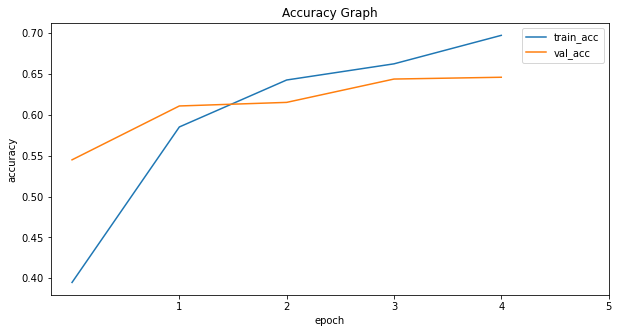

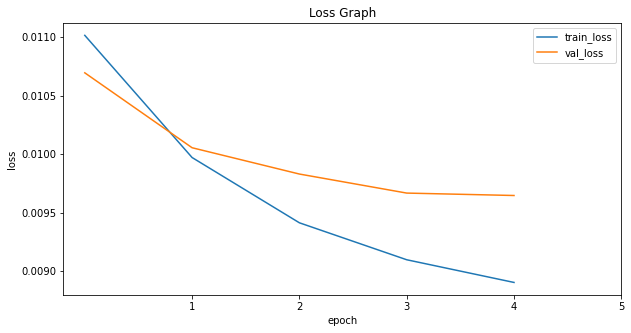

In [18]:
model = train_model(epochs, train_dataloader, valid_dataloader, model, loss_fn, optimizer)

In [19]:
preds, targets = evaluation(model, valid_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.72s/it]


              precision    recall  f1-score   support

           1      0.580     0.593     0.587       140
           2      0.000     0.000     0.000        26
           3      0.750     0.701     0.725       137
           4      0.625     0.757     0.685       152

    accuracy                          0.646       455
   macro avg      0.489     0.513     0.499       455
weighted avg      0.613     0.646     0.627       455



/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

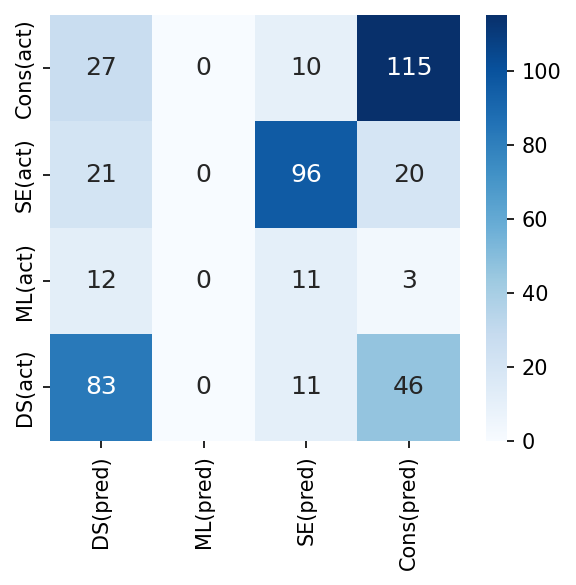

In [20]:
labels = [1, 2, 3, 4]
l_preds = list(map(lambda x: x + 1, preds))
l_targets = list(map(lambda x: x + 1, targets))
re_labels = ["DS", "ML", "SE", "Cons"]

# create confusion matrix
conf_mx = confusion_matrix(l_targets, l_preds, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

# visualization
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
plt.savefig('./results/bert_epoch_5_heatmap.png')

print(classification_report(l_targets, l_preds, labels=labels, digits=3))

# Submit 

In [21]:
# train model using all data
submit_dataset = BertDataset(cleaned_train, tokenizer, max_length=max_length, training=True) 
submit_dataloader = DataLoader(dataset=submit_dataset, shuffle=True, batch_size=batch_size)

In [22]:
model = BERT()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss(alpha=alpha, gamma=0.5, reduction="sum") # default (gamma = 2.0)
optimizer = optim.AdamW(model.parameters())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# if we don't want to re-train bert parameters (we want to train only the last layer)
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.pooler.parameters():
    param.requires_grad = True
# print(model.bert.pooler.parameters())

In [24]:
model = train_submit_model(epochs, submit_dataloader, model, loss_fn, optimizer)

Epoch 1/5
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:45<00:00,  3.83s/it]


Epoch 2/5
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 3/5
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 4/5
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 5/5
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


In [25]:
torch.save(model.state_dict(), './results/bert_epoch_5.pth')

In [26]:
# model.load_state_dict(torch.load('./results/bert_epoch_20.pth'))

In [27]:
test_dataset = BertDataset(cleaned_test, tokenizer, max_length=max_length, training=False) 
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

In [28]:
pred_sub = prediction(model, test_dataloader)
pred_sub = list(map(lambda x: x + 1, pred_sub))

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.15s/it]


In [29]:
sample_submit_df = pd.DataFrame(list(zip(list(test['id'].values), pred_sub)), columns=["id", "pred"])
# sample_submit_df.to_csv('../ensemble/bert/test.csv', header=None, index=None)

1    564
3    506
4    447
Name: pred, dtype: int64


<AxesSubplot:>

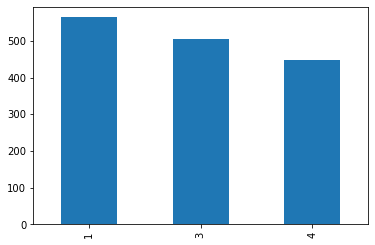

In [30]:
print(sample_submit_df['pred'].value_counts())
sample_submit_df['pred'].value_counts().plot(kind = 'bar')